In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import multiprocessing as mp
from scipy.optimize import fmin_l_bfgs_b
from tqdm import tqdm
import decimal
%matplotlib inline
D = decimal.Decimal

#Эти параметры относятся к конкретному датасету RCV


In [0]:
number_of_features = 47236
number_of_objects = 20242
# number_of_objects = 5000
server_data_file = 'server_data_sampled.txt'
train_data_file = 'rcv1_train.txt'
test_data_file = 'rcv1_test'

#Вспомогательные функции и алгоритм метода


    1 - Надо переписать функцию phi чтобы ела массив точек вместо одной
    2 - убрать костыль с ограничением на число читаемых строк


In [0]:

def logit(z):
    return 1 / (1 + np.exp( (-1) * z) )

def quad_eq_roots(a,b,c):
    d = (b**2) - (4*a*c)
    sol1 = ((-1) * b - np.sqrt(d)) / (2 * a)
    sol2 = ((-1) * b + np.sqrt(d)) / (2 * a)
    if sol2 > sol1:
        if sol2 <= 0:
            print('oh J - 1') 
        return sol2
    else:
        if sol1 <= 0:
            print('oh J - 2') 
        return sol1

def l(x, y, a, Lambda):
    return float( (1 + D( (-1) * y * (x @ a) ).exp() ).ln() ) + 0.5 * Lambda *  np.linalg.norm(x)**2
    

def grad_l(x, y, a, Lambda):
    d = D( (-1) * y * (x @ a) ).exp() 
    return Lambda * x + float(d / (1 + d)) * (-1) * y * a


def f_and_grad_f(x, data_file, Lambda):
    func = 0
    grad_f = np.zeros(number_of_features)
    num_lines = 0
    with open(data_file, 'r') as f:     
        for line in f:
            num_lines += 1
            a = np.zeros(number_of_features)
            for i, item in enumerate(line.split(' ')):
                if i != 0:
                    a[int(item.split(':')[0]) - 1] = float(item.split(':')[1])
                else:
                    y = int(item)
            one_point_loss = l(x, y, a, Lambda)
            func += one_point_loss
            one_point_grad_loss = grad_l(x, y, a, Lambda)
            grad_f += one_point_grad_loss
    return func / num_lines , grad_f / num_lines


def phi_and_grad_phi(x, Lambda):
    f, grad_f = f_and_grad_f(x, server_data_file, Lambda)
    phi = f + 0.5 * Mu * (np.linalg.norm(x))**2
    grad_phi = grad_f + Mu * x
    return phi, grad_phi


def V_and_grad_V(x, grad_F, eta, beta, v, y, Lambda):
    phi_x, grad_phi_x = phi_and_grad_phi(x, Lambda)
    phi_y, grad_phi_y = phi_and_grad_phi(y, Lambda)
    phi_v, grad_phi_v = phi_and_grad_phi(v, Lambda)

    V = eta * grad_F @ x + (1 - beta) * (phi_x - phi_v - grad_phi_v @ (x-v) ) + beta * (phi_x - phi_y - grad_phi_y @ (x-y) )
    grad_V = eta * grad_F + grad_phi_x - beta * grad_phi_y - (1 - beta) * grad_phi_v
    return V, grad_V 


def SPAG(L, sigma, num_iter):
    x = np.empty([num_iter + 1, number_of_features])

    print('start local min')
    x_start, f_at_x_start, info = fmin_l_bfgs_b(func= f_and_grad_f, x0= np.zeros(number_of_features), fprime= None, 
                                           args= [server_data_file, Lambda], approx_grad= False, 
                                           bounds= [(None, None)] * number_of_features, maxiter= 20)
    print('end local min')

    x[0] = x_start
    v = x[0]
    A = 0
    B = 1
    G = 1

    with mp.Pool(processes = num_machines) as pool: 
        for t in range(num_iter):           
            print('iteration ', t)   
            G = 0.5 * max(1, 0.5 * G)
            #тут начинается цикл repeat .. until 
            
            print('round 0')
            
            G = 2 * G
            a = quad_eq_roots(sigma - L * G, sigma * A + B, A * B)
            A = A + a
            B = B + a * sigma
            alpha = a / A 
            beta = a / B * sigma
            eta = a / B

            y = ( (1 - alpha) * x[t] + alpha * (1 - beta) * v ) / (1 - alpha * beta)
            
            print('начал градиент паралллельно')
            # Распараллеливание вычисления градиента
            results = pool.starmap_async(f_and_grad_f, [(y, 'data_' + str(n+1) + '.txt', Lambda) for n in range(num_machines)])
            funcs_and_grads = results.get()

            grad_F_at_y = 0
            for item in funcs_and_grads:
                grad_F_at_y += item[1]
            grad_F_at_y = grad_F_at_y / num_machines
            print('закончил градиент паралллельно')
    
            print('начал min V')
            v_next, min_V_t, info_V = fmin_l_bfgs_b(func= V_and_grad_V, x0= v, fprime= None, args= [grad_F_at_y, eta, beta, v, y, Lambda], 
                                                approx_grad= False, bounds= [(None, None)] * number_of_features, maxiter= 5)
            x[t+1] = (1 - alpha) * x[t] + alpha * v_next
            print('кончил min V ')

            #Проверка условия на продолжение цикла repeat .. until
            phi_x, grad_phi_x = phi_and_grad_phi(x[t+1], Lambda)
            phi_y, grad_phi_y = phi_and_grad_phi(y, Lambda)
            phi_v, grad_phi_v = phi_and_grad_phi(v, Lambda)
            phi_v_next, grad_phi_v_next = phi_and_grad_phi(v_next, Lambda)
            
            D_phi_at_x_y = phi_x - phi_y - grad_phi_y @ (x[t+1] - y)
            D_phi_at_v_next_v = phi_v_next - phi_v - grad_phi_v @ (v_next - v)
            D_phi_at_v_next_y = phi_v_next - phi_y - grad_phi_y @ (v_next - y)

            condition = D_phi_at_x_y <= alpha**2 * G * ( (1 - beta) * D_phi_at_v_next_v + beta * D_phi_at_v_next_y ) 
            
            print('end round 0')
            rount = 0
            
            while not condition:
                rount += 1
                print('round ', rount)
                
                G = 2 * G
                a = quad_eq_roots(sigma - L * G, sigma * A + B, A * B)
                A = A + a
                B = B + a * sigma
                alpha = a / A 
                beta = a / B * sigma
                eta = a / B

                y = ( (1 - alpha) * x[t] + alpha * (1 - beta) * v ) / (1 - alpha * beta)
                
                print('начал градиент паралллельно')
                # Распараллеливание вычисления градиента
                results = pool.starmap_async(f_and_grad_f, [(y, 'data_' + str(n+1) + '.txt', Lambda) for n in range(num_machines)])
                funcs_and_grads = results.get()

                grad_F_at_y = 0
                for item in funcs_and_grads:
                    grad_F_at_y += item[1]
                grad_F_at_y = grad_F_at_y / num_machines
                print('закончил градиент паралллельно')
        
                print('начал min V')
                v_next, min_V_t, info_V = fmin_l_bfgs_b(func= V_and_grad_V, x0= v, fprime= None, args= [grad_F_at_y, eta, beta, v, y, Lambda], 
                                                    approx_grad= False, bounds= [(None, None)] * number_of_features, maxiter= 5)
                x[t+1] = (1 - alpha) * x[t] + alpha * v_next
                print('кончил min V')

                #Проверка условия на продолжение цикла repeat .. until
                phi_x, grad_phi_x = phi_and_grad_phi(x[t+1], Lambda)
                phi_y, grad_phi_y = phi_and_grad_phi(y, Lambda)
                phi_v, grad_phi_v = phi_and_grad_phi(v, Lambda)
                phi_v_next, grad_phi_v_next = phi_and_grad_phi(v_next, Lambda)
                
                D_phi_at_x_y = phi_x - phi_y - grad_phi_y @ (x[t+1] - y)
                D_phi_at_v_next_v = phi_v_next - phi_v - grad_phi_v @ (v_next - v)
                D_phi_at_v_next_y = phi_v_next - phi_y - grad_phi_y @ (v_next - y)

                condition = D_phi_at_x_y <= alpha**2 * G * ( (1 - beta) * D_phi_at_v_next_v + beta * D_phi_at_v_next_y ) 
                            
                print('end round ', rount)

            # print('x = {} , y = {} , v = {} , v_next = {}'.format(x[t+1], y, v, v_next))

            v = v_next
    return x


    
def indices_for_server(number_to_sample):
    labels = []
    with open(train_data_file, 'r') as f:     
        for i, line in enumerate(f):
            if i < number_of_objects:
                labels.append( int(line.split(' ')[0]) )
    labels = np.array(labels)
    indices_of_ones = np.where(labels == 1)[0]
    num_ones_total = len(indices_of_ones)
    num_ones_server = round(num_ones_total / number_of_objects * number_to_sample)
    np.random.shuffle(indices_of_ones)
    ones_for_server = indices_of_ones[0:int(num_ones_server - 1)]

    indices_of_minus_ones = np.where(labels == -1)[0]
    num_minus_ones_total = len(indices_of_minus_ones)
    num_minus_ones_server = number_to_sample - num_ones_server
    np.random.shuffle(indices_of_minus_ones)
    minus_ones_for_server = indices_of_minus_ones[0:int(num_minus_ones_server - 1)]

    server_indices = np.concatenate([ones_for_server, minus_ones_for_server])
    return server_indices

    # Порядковые номера строк для сервера с сохранением баланса классов и случайным выбором (порядок 1 -1)

def F(x, data_file, Lambda):
    func = 0
    num_lines = 0
    with open(data_file, 'r') as f:     
        for line in f:
            num_lines += 1
            a = np.zeros(number_of_features)
            for i, item in enumerate(line.split(' ')):
                if i != 0:
                    a[int(item.split(':')[0]) - 1] = float(item.split(':')[1])
                else:
                    y = int(item)
            one_point_loss = l(x, y, a, Lambda)
            func += one_point_loss
    return func / num_lines


    
def accuracy(test_data, num_test_objects):
    true_labels = []
    with open(test_data, 'r') as f:     
        for i, line in enumerate(f):
            if i < test_objects:
                true_labels.append( int(line.split(' ')[0]) )
    

#Разделение данных между машинами-работниками

Данные каждой машины в кластере хранятся в своем файле

In [0]:
def work_for_slaves():
    total_num_lines = number_of_objects
    parts_length = []
    batch = total_num_lines // num_machines
    rest = total_num_lines % num_machines

    for _ in range(num_machines): 
        parts_length.append(batch)

    for i in range(rest):
        parts_length[i] += 1

    with open(train_data_file, 'r') as f:    
        for i in range(num_machines):
            with open('data_' + str(i+1) + '.txt', 'w') as file_local:    
                for _ in range(parts_length[i]):
                    file_local.write(f.readline())

Сервер получает равномерно случайно выбранные данные


In [0]:
def work_for_master(number_to_sample):
    indices_to_select_for_server = indices_for_server(number_to_sample) 

    with open(train_data_file, 'r') as f:    
        with open(server_data_file, 'w') as file_local:    
            for i, line in enumerate(f):
                if i in indices_to_select_for_server:
                    file_local.write(line)

#График зависимости поточечно усредненной loss функции от номера итерации

In [0]:
def find_F_at_iters(x_at_iterations, Lambda):
    y = []
    count = 0
    with mp.Pool(processes = num_machines) as pool:
        for item in x_at_iterations:
            count += 1
            print('Point ', count)
            result = pool.starmap_async(F, [(item, 'data_' + str(n+1) + '.txt', Lambda) for n in range(num_machines)])
            loss_values = result.get()
            y.append(sum(loss_values) / num_machines)
    return y

In [0]:
def plot_F_at_iters_and_log(lambd, mu, sampled_data, y):
    x = range(iterations_number + 1)
    plt.style.use('seaborn-whitegrid')
    plt.plot(x, y, 'o', color='blue');
    plt.title('Loss over iters')
    plt.xlabel(f'$iter$')
    plt.ylabel(f'$Loss$')
    # plt.legend(['1e9 points'], frameon = True)
    plt.savefig('sampled_' + str(sampled_data) + '_lambda_' + str(Lambda) + '_mu_' + str(Mu) +'.png')
    print('sampled_' + str(sampled_data) + '_lambda_' + str(Lambda) + '_mu_' + str(Mu) +'.png')
    plt.show()
    plt.clf()
    with open('plot_data_logs-1.txt', 'a') as f:      
        f.write('sampled ' + str(sampled_data) + ' lambda ' + str(lambd) + ' mu ' + str(mu) + ' ' + 
                ' '.join(map(str, y)) + '\n')

#Гиперпараметры

In [0]:
num_machines = 20
sampled_vectors_at_server = number_of_objects // 10

L_F_phi = 1
Mu = 1e-5
Lambda = 1e-7
sigma_F_phi = Lambda / (Lambda + 2 * Mu)

iterations_number = 19


'''
Lambda_s = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
Mu_s = [1e-4, 1e-5, 1e-6]
grades = [35, 30, 25, 20, 15, 10]
'''
# Lambda_s = [1e-8]
# Mu_s = [1e-6]
# grades = [10]

# sample_grade = 10

'\nLambda_s = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]\nMu_s = [1e-4, 1e-5, 1e-6]\ngrades = [35, 30, 25, 20, 15, 10]\n'

#Один раз 

In [0]:
work_for_slaves()
work_for_master(sampled_vectors_at_server)

#Запуск по сетке



In [0]:
for Mu in Mu_s:
    for Lambda in Lambda_s:
        for sample_grade in grades:
            sampled_vectors_at_server = number_of_objects // sample_grade
            sigma_F_phi = Lambda / (Lambda + 2 * Mu)
            work_for_master(sampled_vectors_at_server)
            x_s = SPAG(L_F_phi, sigma_F_phi, iterations_number) 
            y_s = find_F_at_iters(x_s, Lambda)
            plot_F_at_iters_and_log(Lambda, Mu, sampled_vectors_at_server, y_s)

#Применение Spag 

In [0]:
xxx_s = SPAG(L_F_phi, sigma_F_phi, iterations_number) 
ys_spag = find_F_at_iters(xxx_s, Lambda)

start local min
end local min
iteration  0
round 0
начал градиент паралллельно
закончил градиент паралллельно
начал min V
кончил min V 
end round 0
iteration  1
round 0
начал градиент паралллельно
закончил градиент паралллельно
начал min V
кончил min V 
end round 0
round  1
начал градиент паралллельно
закончил градиент паралллельно
начал min V
кончил min V
end round  1
iteration  2
round 0
начал градиент паралллельно
закончил градиент паралллельно
начал min V
кончил min V 
end round 0
iteration  3
round 0
начал градиент паралллельно
закончил градиент паралллельно
начал min V
кончил min V 
end round 0
iteration  4
round 0
начал градиент паралллельно
закончил градиент паралллельно
начал min V
кончил min V 
end round 0
iteration  5
round 0
начал градиент паралллельно
закончил градиент паралллельно
начал min V
кончил min V 
end round 0
iteration  6
round 0
начал градиент паралллельно
закончил градиент паралллельно
начал min V
кончил min V 
end round 0
iteration  7
round 0
начал градиент па

#Другие методы оптимизации

##Применение Nesterov accelerated method

In [0]:
pip install git+https://github.com/amkatrutsa/liboptpy

  Cloning https://github.com/amkatrutsa/liboptpy to /tmp/pip-req-build-nt5na7xb
  Running command git clone -q https://github.com/amkatrutsa/liboptpy /tmp/pip-req-build-nt5na7xb
  Created wheel for liboptpy: filename=liboptpy-0.0.1-cp36-none-any.whl size=11730 sha256=75510f40c449c92b9e14661680d2818b352c6aec41bb4f8a408ae2822ab85f29
  Stored in directory: /tmp/pip-ephem-wheel-cache-vzgat6gz/wheels/8e/6e/38/60496dcf12f2c341e42d932d1403bdaaa17049556fdaba8d40
Successfully built liboptpy


In [0]:
import liboptpy.unconstr_solvers as solvers
import liboptpy.step_size as ss
import liboptpy.restarts as restarts
import scipy.optimize as scopt
import cvxpy

x_start, f_at_x_start, info = fmin_l_bfgs_b(func= f_and_grad_f, x0= np.zeros(number_of_features), fprime= None, 
                                           args= [server_data_file, Lambda], approx_grad= False, 
                                           bounds= [(None, None)] * number_of_features, maxiter= 20)
    

def f(x):
    return F(x, train_data_file, Lambda)

def grad_f(x):
    return f_and_grad_f(x, train_data_file, Lambda)[1]

m_dict = { "Nesterov": solvers.fo.AcceleratedGD(f, grad_f, ss.ConstantStepSize(1e-3)) }

tol = 1e-6
key = "Nesterov"


print("\t {}".format(key))
q = m_dict[key].solve(x_start, iterations_number, tol, disp=True)

# ys = [f(x) for x in m_dict[key].get_convergence()]

# for key in m_dict:
#     print("\t {}".format(key))
#     %timeit m_dict[key].solve(x0, max_iter, tol)


ys_agd = []
count = 0
with mp.Pool(processes = num_machines) as pool:
    for item in m_dict[key].get_convergence():
        count += 1
        print('Point ', count)
        result = pool.starmap_async(F, [(item, 'data_' + str(n+1) + '.txt', Lambda) for n in range(num_machines)])
        loss_values = result.get()
        ys_agd.append(sum(loss_values) / num_machines)


# xs = range(1, iterations_number+2)
# plt.style.use('seaborn-whitegrid')
# plt.plot(xs, ys_agd, 'o', color='green')
# plt.xlabel("Number of iteration")
# plt.ylabel("f(x_k)")

	 Nesterov
Maximum iteration exceeds!
Convergence in 19 iterations
Function value = 0.1470718213420469
Norm of gradient = 0.0022589893621938416
Point  1
Point  2
Point  3
Point  4
Point  5
Point  6
Point  7
Point  8
Point  9
Point  10
Point  11
Point  12
Point  13
Point  14
Point  15
Point  16
Point  17
Point  18
Point  19
Point  20


##Применение L-BFGS

In [0]:
ys_lbfgs = []

def callback_F(x):
    with mp.Pool(processes = num_machines) as pool:
        result = pool.starmap_async(F, [(x, 'data_' + str(n+1) + '.txt', Lambda) for n in range(num_machines)])
        loss_values = result.get()
        y = sum(loss_values) / num_machines
    ys_lbfgs.append(y)


ys_lbfgs.append(F(x_start, train_data_file, Lambda))

print('step 2')

x_optimal, F_at_x_optimal, info2 = fmin_l_bfgs_b(func= f_and_grad_f, x0= x_start, fprime= None, args= [train_data_file, Lambda],
                                                 approx_grad= False, bounds= [(None, None)] * number_of_features,
                                                 maxiter= iterations_number, callback= callback_F)


# xs = range(1, iterations_number + 2)
# plt.style.use('seaborn-whitegrid')
# plt.plot(xs, ys_lbfgs, 'o', color='red');    
# plt.xlabel("Number of iteration")
# plt.ylabel("f(x_k)")

step 2


#Общий график

3|->sampled_2024_lambda_1e-07_mu_1e-05.png


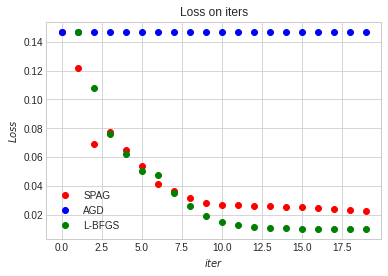

In [0]:
x = range(iterations_number + 1)
plt.style.use('seaborn-whitegrid')
plt.title('Loss on iters')
plt.xlabel(f'$iter$')
plt.ylabel(f'$Loss$')
plt.plot(x, ys_spag, 'o', color='red', label='SPAG')
plt.plot(x, ys_agd, 'o', color='blue', label='AGD')
plt.plot(x[1:], ys_lbfgs, 'o', color='green', label='L-BFGS')
plt.legend()
plt.savefig('3|->sampled_' + str(sampled_vectors_at_server) + '_lambda_' + str(Lambda) + '_mu_' + str(Mu) +'.png')
print('3|->sampled_' + str(sampled_vectors_at_server) + '_lambda_' + str(Lambda) + '_mu_' + str(Mu) +'.png')
plt.show()